In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## keypoints extraction

In [ ]:
!pip install ultralytics

In [3]:
import torch
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os 
import torch
from random import random
import torchvision 
from ultralytics import YOLO
from tqdm import tqdm

import seaborn as sns
from pathlib import Path
import os

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# --- Configuration ---
DATA = "/kaggle/input/vload-preprocessed/Preprocessed_data" 
OUTPUT_VIDEO_PATH = "/kaggle/working/Keypoints/"
if not os.path.exists(OUTPUT_VIDEO_PATH):
    os.makedirs(OUTPUT_VIDEO_PATH)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# --- Load YOLOv11-Pose Model ---
try:
    print("Loading YOLOv26-pose model...")
    # Using 'yolov8n-pose.pt' as it's a standard small model. 
    # Replace with 'yolo11n-pose.pt' if you have that specific file.
    model = YOLO("yolo26n-pose.pt") 
    model.to(DEVICE)
    print(f"YOLO model loaded successfully on device: {DEVICE}")
except Exception as e:
    print(f"Error loading YOLO model: {e}")
    exit()

Loading YOLOv26-pose model...
YOLO model loaded successfully on device: cuda


In [6]:
# --- Keypoint Drawing Utilities (No changes needed here) ---
KEYPOINT_DICT = {
    'nose': 0, 'left_eye': 1, 'right_eye': 2, 'left_ear': 3, 'right_ear': 4,
    'left_shoulder': 5, 'right_shoulder': 6, 'left_elbow': 7, 'right_elbow': 8,
    'left_wrist': 9, 'right_wrist': 10, 'left_hip': 11, 'right_hip': 12,
    'left_knee': 13, 'right_knee': 14, 'left_ankle': 15, 'right_ankle': 16
}
SKELETON_EDGES = [
    (KEYPOINT_DICT['left_shoulder'], KEYPOINT_DICT['right_shoulder']), (KEYPOINT_DICT['left_hip'], KEYPOINT_DICT['right_hip']),
    (KEYPOINT_DICT['left_shoulder'], KEYPOINT_DICT['left_hip']), (KEYPOINT_DICT['right_shoulder'], KEYPOINT_DICT['right_hip']),
    (KEYPOINT_DICT['left_shoulder'], KEYPOINT_DICT['left_elbow']), (KEYPOINT_DICT['left_elbow'], KEYPOINT_DICT['left_wrist']),
    (KEYPOINT_DICT['right_shoulder'], KEYPOINT_DICT['right_elbow']), (KEYPOINT_DICT['right_elbow'], KEYPOINT_DICT['right_wrist']),
    (KEYPOINT_DICT['left_hip'], KEYPOINT_DICT['left_knee']), (KEYPOINT_DICT['left_knee'], KEYPOINT_DICT['left_ankle']),
    (KEYPOINT_DICT['right_hip'], KEYPOINT_DICT['right_knee']), (KEYPOINT_DICT['right_knee'], KEYPOINT_DICT['right_ankle']),
    (KEYPOINT_DICT['nose'], KEYPOINT_DICT['left_eye']), (KEYPOINT_DICT['nose'], KEYPOINT_DICT['right_eye']),
    (KEYPOINT_DICT['left_eye'], KEYPOINT_DICT['left_ear']), (KEYPOINT_DICT['right_eye'], KEYPOINT_DICT['right_ear']),
]

def draw_keypoints(frame, keypoints, confidence_threshold=0.2):
    h, w, _ = frame.shape
    for kp in keypoints:
        y, x, conf = kp
        if conf > confidence_threshold:
            # Note: keypoints are already normalized [y, x], so we multiply by h, w
            cv2.circle(frame, (int(x * w), int(y * h)), 4, (0, 255, 0), -1)

def draw_skeleton(frame, keypoints, confidence_threshold=0.2):
    h, w, _ = frame.shape
    for start_idx, end_idx in SKELETON_EDGES:
        start_kp, end_kp = keypoints[start_idx], keypoints[end_idx]
        if start_kp[2] > confidence_threshold and end_kp[2] > confidence_threshold:
            start_point = (int(start_kp[1] * w), int(start_kp[0] * h))
            end_point = (int(end_kp[1] * w), int(end_kp[0] * h))
            cv2.line(frame, start_point, end_point, (255, 0, 0), 2)

def get_keypoints_from_result(result, frame_h, frame_w):
    """
    Extracts, normalizes, and formats keypoints from a YOLO result.
    Handles multi-person detection by picking the most confident person.
    
    Returns:
        np.ndarray: A NumPy array of shape (17, 3) with normalized [y, x, confidence].
    """
    if result.keypoints is None or len(result.keypoints.data) == 0:
        return np.zeros((17, 3), dtype=np.float32)

    kpts_tensor = result.keypoints.data
    
    # --- Handle multiple people: select the one with the highest avg confidence ---
    if kpts_tensor.shape[0] > 1:
        confidences = kpts_tensor[:, :, 2].mean(dim=1)
        best_person_idx = confidences.argmax()
        person_kpts = kpts_tensor[best_person_idx]
    else:
        person_kpts = kpts_tensor[0]

    # Convert to numpy and normalize
    person_kpts_np = person_kpts.cpu().numpy()
    
    # Format to [y, x, confidence] and normalize
    formatted_kps = np.zeros((17, 3), dtype=np.float32)
    for i in range(17):
        x, y, conf = person_kpts_np[i]
        formatted_kps[i] = [y / frame_h, x / frame_w, conf]
        
    return formatted_kps

def process_and_visualize_video(video_path: str, output_path: str, yolo_model):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    frame_width, frame_height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps, num_frames = int(cap.get(cv2.CAP_PROP_FPS)), int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    #print(f"Processing video: {os.path.basename(video_path)}")
    for _ in tqdm(range(num_frames), desc="Visualizing with YOLO"):
        ret, frame = cap.read()
        if not ret: break

        # --- Run YOLO Inference ---
        # The model expects BGR frames, which cv2.read() provides
        results = yolo_model(frame, verbose=False)
        
        # --- Extract, normalize, and format keypoints ---
        # We process the first (and likely only) result
        keypoints = get_keypoints_from_result(results[0], frame_height, frame_width)

        # --- Drawing on the frame (this happens on CPU) ---
        vis_frame = frame.copy()
        draw_keypoints(vis_frame, keypoints)
        draw_skeleton(vis_frame, keypoints)
        out.write(vis_frame)

    cap.release()
    out.release()
    #print(f"\nVisualization complete! Video saved to: {output_path}")

In [7]:

for label in ["empty","heavy","light"]:
    for i in range(8) : 
        for j in range(3) :
            vid_path = DATA + f"/{label}/ope{i+1}/walk/angle{j+1}.mp4"
            out_path = f"/{label}/ope{i+1}/walk"
            if not os.path.exists(OUTPUT_VIDEO_PATH + out_path) : 
                os.makedirs(OUTPUT_VIDEO_PATH+out_path)
            process_and_visualize_video(vid_path, OUTPUT_VIDEO_PATH+out_path + f"/angle{j+1}.mp4", model)

Visualizing with YOLO: 100%|██████████| 1000/1000 [00:12<00:00, 79.53it/s]


In [8]:
for label in ["empty","heavy","light"]:
    for i in range(8) : 
        for j in range(3) :
            vid_path = DATA + f"/{label}/ope{i+1}/carry/angle{j+1}.mp4"
            out_path = f"/{label}/ope{i+1}/carry"
            if not os.path.exists(OUTPUT_VIDEO_PATH + out_path) : 
                os.makedirs(OUTPUT_VIDEO_PATH+out_path)
            process_and_visualize_video(vid_path, OUTPUT_VIDEO_PATH+out_path + f"/angle{j+1}.mp4", model)

Visualizing with YOLO: 100%|██████████| 1000/1000 [00:12<00:00, 80.73it/s]


## RAFT Testing

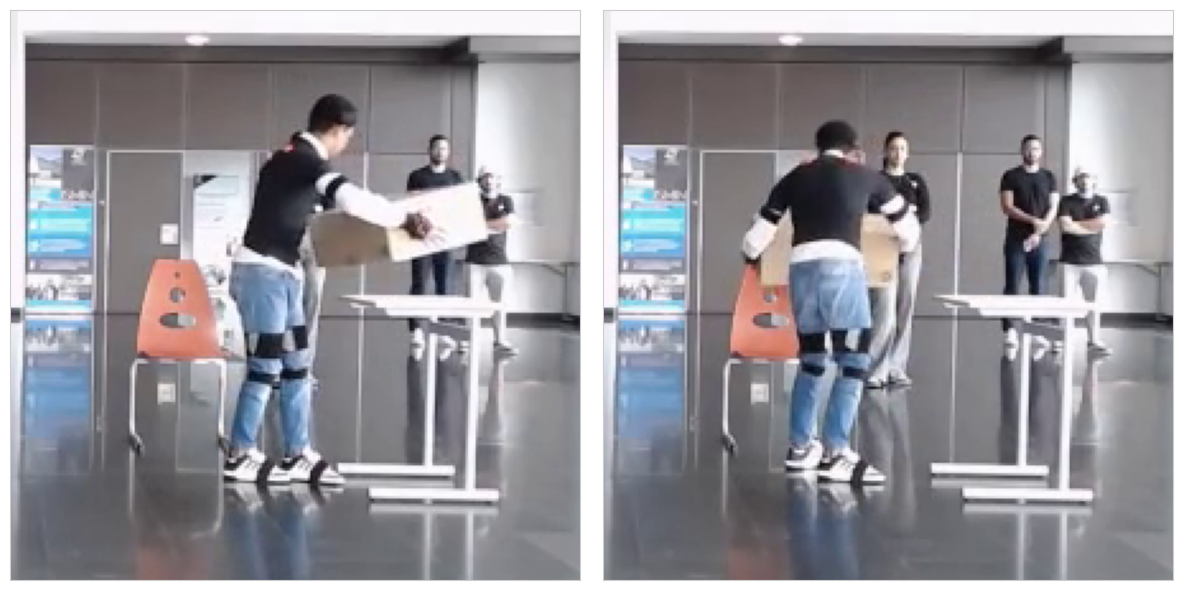

In [39]:
import cv2
import torch
import torchvision.transforms.functional as F

def read_video_cv2(path):
    cap = cv2.VideoCapture(path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(torch.from_numpy(frame))
    cap.release()
    return torch.stack(frames)  # (T, H, W, C)

def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

frames = read_video_cv2("/kaggle/input/vload-preprocessed/Preprocessed_data/empty/ope1/carry/angle1.mp4")
frames = frames.permute(0, 3, 1, 2)  # (T, C, H, W)

img1_batch = torch.stack([frames[100], frames[150]])
img2_batch = torch.stack([frames[101], frames[151]])
plot(img1_batch)


In [40]:
import torchvision.transforms as T
def preprocess(batch):
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
            T.Resize(size=(224, 224)),
        ]
    )
    batch = transforms(batch)
    return batch


# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

img1_batch = preprocess(img1_batch).to(device)
img2_batch = preprocess(img2_batch).to(device)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

shape = torch.Size([2, 3, 224, 224]), dtype = torch.float32


In [41]:
from torchvision.models.optical_flow import raft_large

model = raft_large(pretrained=True, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

type = <class 'list'>
length = 12 = number of iterations of the model


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Large_Weights.C_T_SKHT_V2`. You can also use `weights=Raft_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([2, 2, 224, 224]) = (N, 2, H, W)
min = -2.4337100982666016, max = 1.4429707527160645


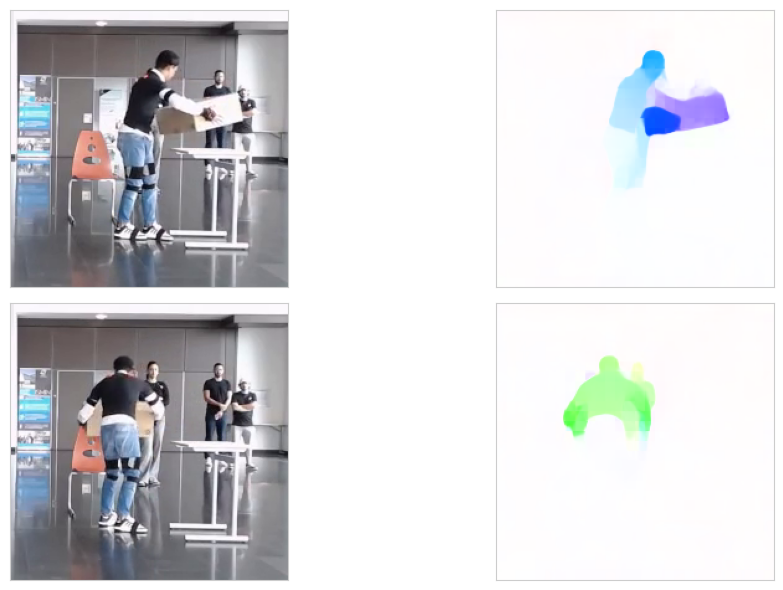

In [43]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)

In [61]:
grid

[[tensor([[[0.9255, 0.9333, 0.9333,  ..., 0.9882, 0.9882, 0.9882],
           [0.9255, 0.9333, 0.9333,  ..., 0.9882, 0.9882, 0.9882],
           [0.9255, 0.9333, 0.9333,  ..., 0.9882, 0.9882, 0.9882],
           ...,
           [0.5294, 0.5216, 0.4980,  ..., 0.5020, 0.5137, 0.5137],
           [0.5255, 0.5137, 0.4941,  ..., 0.5020, 0.5137, 0.5176],
           [0.5216, 0.5098, 0.4941,  ..., 0.5137, 0.5176, 0.5216]],
  
          [[0.9137, 0.9216, 0.9216,  ..., 0.9765, 0.9765, 0.9765],
           [0.9137, 0.9216, 0.9216,  ..., 0.9765, 0.9765, 0.9765],
           [0.9137, 0.9216, 0.9216,  ..., 0.9765, 0.9765, 0.9765],
           ...,
           [0.5333, 0.5255, 0.5020,  ..., 0.5255, 0.5373, 0.5373],
           [0.5294, 0.5176, 0.4980,  ..., 0.5255, 0.5373, 0.5412],
           [0.5255, 0.5137, 0.4980,  ..., 0.5373, 0.5412, 0.5451]],
  
          [[0.9294, 0.9373, 0.9373,  ..., 0.9922, 0.9922, 0.9922],
           [0.9294, 0.9373, 0.9373,  ..., 0.9922, 0.9922, 0.9922],
           [0.9294, 0.